In [1]:
# Import PyTorch
import torch

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocessing and visualization

Loading the Dataset:

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18095044.15it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 363963.43it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6109433.08it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14290057.57it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
classes = train_data.classes
print('Clasess Count: ', len(classes))
print('Classes: ', classes)

Clasess Count:  10
Classes:  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
pics = []
for i in range(10):
    class_indices = torch.where(train_data.targets == i)[0]
    class_pic = train_data.data[class_indices[0]]
    pics.append(class_pic)

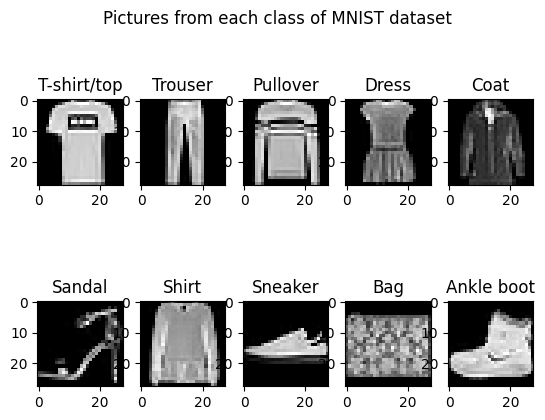

In [6]:
fig, axes = plt.subplots(2, 5)
fig.suptitle('Pictures from each class of MNIST dataset')

for i in range(2):
    for j in range(5):
        axes[i, j].imshow(pics[i * 5 + j], cmap='gray')
        axes[i, j].set_title(classes[i * 5 + j])

# 4.1

Advantages of very small batch sizes:
1. Faster convergence: Small batch sizes make model update parameters more frequently, leading to faster convergence. It helps when there is a time constraint for training.
2. Less memory usage: Small batch sizes need less memory to store intermediate activations and gradients during training. It is useful when computational resources are limited.

Disadvantages of very small batch sizes:
1. Noisy gradients: Small batch sizes introduce more noise in gradient estimation due to the limited number of samples. This can lead to unstable updates and slower convergence.
2. Slower training: Training with small batch sizes can be slower as the model needs to process and update parameters more frequently. Data loading and parameter updates become more time-consuming.

Advantages of very large batch sizes:
1. Faster training: Large batch sizes process more samples in parallel, leveraging efficient parallel computation on modern hardware for faster training.
2. Stable gradients: With more samples in each batch, gradient estimation becomes more stable, resulting in smoother parameter updates and faster convergence.

Disadvantages of very large batch sizes:
1. Memory requirements: Very large batch sizes need more memory to store intermediate activations and gradients, which can be challenging with limited GPU memory.
2. Generalization issues: Large batch sizes may lead to worse generalization compared to small batch sizes. The model may overfit to specific batch samples instead of learning diverse patterns from the entire dataset.


# 4.2
The **shuffle** parameter of the **Torch DataLoader** determines whether to shuffle🔀 the dataset during training. It should be used when we want to introduce randomness in the order of the samples, which helps in reducing any bias or patterns that may exist in the data and prevents the model from memorizing the order of the samples.

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# 4.3
Different batch sizes can affect the model's performance and accuracy. Smaller batch sizes may lead to faster convergence but can result in noisier gradients and slower training, while larger batch sizes can provide stable gradients but may suffer from overfitting and slower convergence.

## Data Classification

# 5.1
Because many neural network arcs, such as fully connected layers, require a 1-dim input. Flattening the input allows us to feed it into these layers, ensuring compatibility and enabling the network to learn patterns and features across the entire image.

In [8]:
from torch import nn
class ModelFashionMNIST(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int): # You can add more parameters if you wish, e.g. more hidden layers.
        super().__init__()
        self.layer_stack = nn.Sequential(
            # Add layers
            # YOUR CODE HERE
            nn.Flatten(),
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

After creating your instance of model, you can use GPU for training it (if available) by the following code:

In [9]:
model = ModelFashionMNIST(input_shape=28*28, hidden_units=128, output_shape=10)
model = model.to(device)

#### Setup loss, optimizer and evaluation metrics

In [10]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Implementing training and test loops

In [11]:
# learning_rate =
epochs = 10

for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    print("Epoch {}/{}".format(epoch, epochs))
    print("-"*10)
    # Training loop
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Clear gradients

        outputs = model(images)  # Forward pass
        loss = loss_fn(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item() * images.size(0)

    # Test loop
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    print("Train Loss is:{:.4f}, Test Loss is:{:.4f}".format(train_loss, test_loss))

Epoch 0/10
----------
Train Loss is:0.5454, Test Loss is:0.4549
Epoch 1/10
----------
Train Loss is:0.3992, Test Loss is:0.4049
Epoch 2/10
----------
Train Loss is:0.3574, Test Loss is:0.3789
Epoch 3/10
----------
Train Loss is:0.3325, Test Loss is:0.3552
Epoch 4/10
----------
Train Loss is:0.3113, Test Loss is:0.3583
Epoch 5/10
----------
Train Loss is:0.2958, Test Loss is:0.3512
Epoch 6/10
----------
Train Loss is:0.2829, Test Loss is:0.3376
Epoch 7/10
----------
Train Loss is:0.2729, Test Loss is:0.3504
Epoch 8/10
----------
Train Loss is:0.2608, Test Loss is:0.3509
Epoch 9/10
----------
Train Loss is:0.2529, Test Loss is:0.3198


##### Implementing Evaluation

In [12]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               ):

    model.eval()  # Put the model in evaluation mode
    loss, acc = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            outputs = model(X)  # Make predictions with the model
            batch_loss = loss_fn(outputs, y)
            batch_acc = accuracy_fn(outputs, y)

            loss += batch_loss.item() * X.size(0)
            acc += batch_acc.item() * X.size(0)

    avg_loss = loss / len(data_loader.dataset)
    avg_acc = acc / len(data_loader.dataset)

    return {'loss': avg_loss, 'accuracy': avg_acc}